In [1]:
!pip install transformers datasets torchaudio librosa soundfile scikit-learn matplotlib seaborn --quiet
import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.6 MB/s eta 0:00:00
Using device: cuda


In [2]:
class ESC50Dataset(Dataset):
    def __init__(self, csv_file, audio_dir, feature_extractor, max_length=16000*5):
        self.metadata = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.feature_extractor = feature_extractor
        self.max_length = max_length
        self.label_encoder = LabelEncoder()
        self.metadata['encoded_target'] = self.label_encoder.fit_transform(self.metadata['target'])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['filename'])
        label = row['encoded_target']

        try:
            audio, _ = librosa.load(audio_path, sr=16000)
            if len(audio) > self.max_length:
                audio = audio[:self.max_length]
            else:
                audio = np.pad(audio, (0, self.max_length - len(audio)))
        except:
            audio = np.zeros(self.max_length)

        inputs = self.feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        return {
            'input_values': inputs.input_values.squeeze(),
            'label': torch.tensor(label, dtype=torch.long),
            'filename': row['filename']
        }


In [3]:
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, model_name="facebook/wav2vec2-base", num_classes=50, freeze_base=False):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)
        if freeze_base:
            for param in self.wav2vec2.parameters():
                param.requires_grad = False
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_classes)

    def forward(self, input_values, attention_mask=None):
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        pooled = torch.mean(outputs.last_hidden_state, dim=1)
        pooled = self.dropout(pooled)
        return self.classifier(pooled)


In [4]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    for batch in dataloader:
        inputs, labels = batch['input_values'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['input_values'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(dataloader), correct / len(dataloader.dataset), all_preds, all_labels


In [5]:
# Simulated dataset
df = pd.DataFrame({
    'filename': [f'dummy_{i:03d}.wav' for i in range(100)],
    'fold': np.random.randint(1, 6, size=100),
    'target': np.random.randint(0, 50, size=100),
    'category': [f'class_{i % 10}' for i in range(100)]
})
df.to_csv("esc50_dummy.csv", index=False)

os.makedirs("dummy_audio", exist_ok=True)
for i in range(100):
    dummy_audio = np.random.randn(16000 * 5) * 0.1
    np.save(f"dummy_audio/dummy_{i:03d}.npy", dummy_audio)  # Save as .npy for simplicity


In [6]:
class DummyESC50Dataset(Dataset):
    def __init__(self, metadata_csv, audio_folder, feature_extractor):
        self.metadata = pd.read_csv(metadata_csv)
        self.audio_folder = audio_folder
        self.feature_extractor = feature_extractor
        self.max_length = 16000 * 5

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        audio = np.load(os.path.join(self.audio_folder, row['filename'].replace('.wav', '.npy')))
        if len(audio) < self.max_length:
            audio = np.pad(audio, (0, self.max_length - len(audio)))
        else:
            audio = audio[:self.max_length]
        inputs = self.feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        return {
            'input_values': inputs.input_values.squeeze(),
            'label': torch.tensor(row['target'], dtype=torch.long)
        }

# Load feature extractor and dataset
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
train_dataset = DummyESC50Dataset("esc50_dummy.csv", "dummy_audio", feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=8)


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [7]:
model = Wav2Vec2Classifier(num_classes=50, freeze_base=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(3):
    print(f"\nEpoch {epoch+1}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]


Epoch 1
Train Loss: 3.9550, Accuracy: 0.0100
Val   Loss: 3.9390, Accuracy: 0.0300

Epoch 2
Train Loss: 3.8826, Accuracy: 0.0400
Val   Loss: 3.9191, Accuracy: 0.0300

Epoch 3
Train Loss: 3.8796, Accuracy: 0.0100
Val   Loss: 3.9016, Accuracy: 0.0400


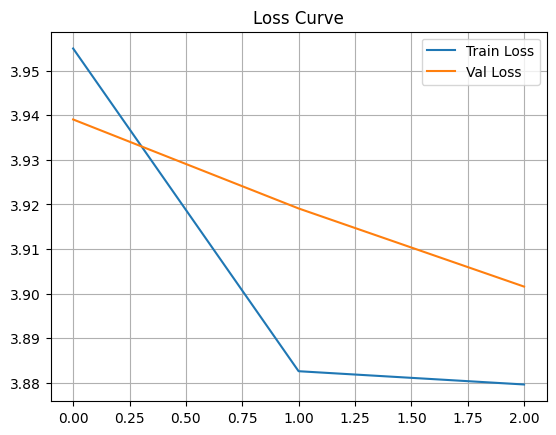

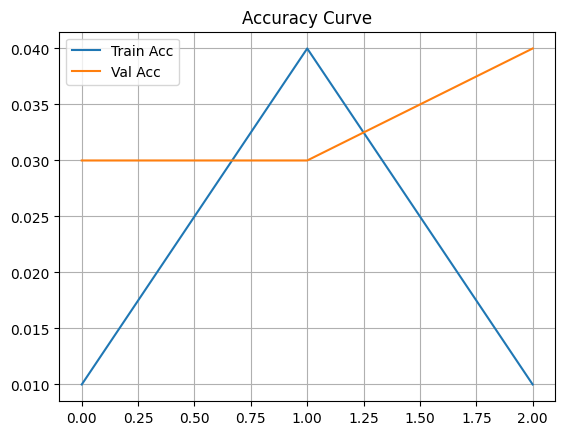


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         6
           2       0.17      0.25      0.20         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         3
          15       0.04      0.75      0.07         4
          16       0.00      0.00      0.00         4
   

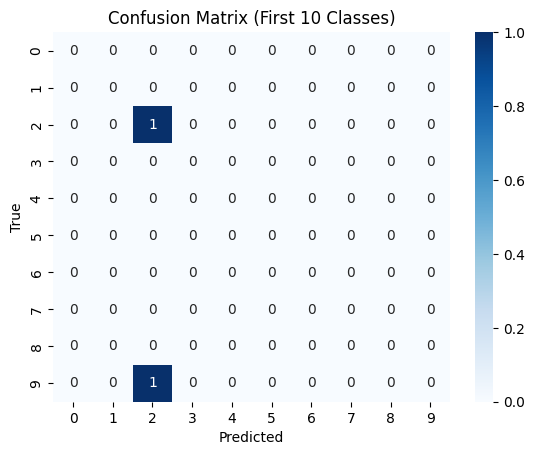

In [8]:
# Loss curve
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy curve
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds))

# Confusion matrix (first 10 classes for readability)
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm[:10, :10], annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (First 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
